In [1]:
#Carga librerias
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [6]:
#Carga dataset
df = pd.read_csv("sample_superstore_processed.csv")

In [9]:
#Creacion de variables
df["sales_theoretical"] = df["Sales"] / (1 - df["Discount"])
df["estimated_cost"] = df["Sales"] - df["Profit"]

df["margin_real"] = df["Profit"]
df["margin_theoretical"] = df["sales_theoretical"] - df["estimated_cost"]

df["margin_leakage"] = df["margin_theoretical"] - df["margin_real"]
df["discount_leakage"] = df["sales_theoretical"] - df["Sales"]

In [20]:
#Calculo de margen teorico, real y perdida.
total_theoretical = df["margin_theoretical"].sum()
total_real = df["margin_real"].sum()
total_leakage = df["margin_leakage"].sum()

print(f"Theoretical Margin: ${total_theoretical:,.2f}")
print(f"Real Margin:        ${total_real:,.2f}")
print(f"Margin Leakage:     ${total_leakage:,.2f}")

Theoretical Margin: $853,131.20
Real Margin:        $286,397.02
Margin Leakage:     $566,734.18


In [21]:
#Calculo de perdida por descuentos
discount_leakage_total = df["discount_leakage"].sum()
print(f"Discount Leakage: ${discount_leakage_total:,.2f}")

Discount Leakage: $566,734.18


Vemos que casi el 100% de la erosión de margen se explica por los descuentos. Esto indica que el principal factor de pérdida de margen es la política de precios, más que los costos de producto, la logística o la composición de los clientes

In [36]:
#Que productos estan generando perdida? (No profit)
subcat_leakage = df.groupby("Sub-Category")["margin_real"].sum().sort_values()

subcat_leakage.map(lambda x: f"${x:,.2f}")

Sub-Category
Tables         $-17,725.48
Bookcases       $-3,472.56
Supplies        $-1,189.10
Fasteners          $949.52
Machines         $3,384.76
Labels           $5,546.25
Art              $6,527.79
Envelopes        $6,964.18
Furnishings     $13,059.14
Appliances      $18,138.01
Storage         $21,278.83
Chairs          $26,590.17
Binders         $30,221.76
Paper           $34,053.57
Accessories     $41,936.64
Phones          $44,515.73
Copiers         $55,617.82
Name: margin_real, dtype: str

Que una subcategoría tenga ganancias positivas no significa que los descuentos sean inofensivos. Significa que esos productos cuentan con una estructura de margen o poder de fijación de precios suficiente para absorber reducciones promocionales, a diferencia de categorías estructuralmente débiles como Tables, Bookcases o Supplies

In [26]:
#Cuanto descuento hay en cada segmento?
seg_leakage = df.groupby("Segment")["margin_leakage"].sum()
seg_leakage.map(lambda x: f"${x:,.2f}")

Segment
Consumer       $295,070.40
Corporate      $157,849.30
Home Office    $113,814.47
Name: margin_leakage, dtype: str

Casi la mitad del margen total perdido por descuentos se concentra en el segmento de Consumers, lo que lo convierte en el principal factor de la erosión general del margen.
Esta concentración sugiere que el problema no está distribuido de manera uniforme entre la base de clientes, sino que se amplifica dentro de un segmento específico. Varios factores pueden explicar este patrón.
- El primero es un efecto de volumen: los Consumers representan una gran proporción de las ventas totales, por lo que incluso niveles de descuento estándar pueden traducirse en un impacto significativo sobre el margen. 
- El segundo factor podría ser la intensidad del descuento. Si la tasa promedio de descuento aplicada a las transacciones de Consumers es mayor que en otros segmentos, la propia estrategia de precios puede estar contribuyendo directamente a la erosión del margen. 
- Por último, la composición de productos desempeña un papel crítico. Si las compras de Consumers se concentran en productos de menor margen, hay menos margen disponible para absorber descuentos, lo que provoca un deterioro más rápido de la rentabilidad.
En conjunto, estos elementos sugieren que la pérdida de margen en el segmento de Consumers probablemente se debe a una combinación de escala, política de precios y diferencias estructurales de margen.

DISCLAIMER: En este dataset "Ship Mode" se trata como una variable descriptiva y de comportamiento, más que como un factor de costo o financiero. El dataset no proporciona costos de envío explícitos, y todos los cálculos de beneficio (Profit / margin_real) ya representan el margen de contribución final, incluyendo cualquier costo implícito. Por lo tanto, el envío no será analizado como una fuente de pérdida de margen. En cambio, se utilizará para explorar patrones en las características de los pedidos, como los descuentos promedio o la distribución de beneficios según los distintos tipos de envío, proporcionando información sobre el comportamiento del cliente y las políticas de descuentos

In [31]:
#Rentanilidad por tipo de envio
ship_leakage = df.groupby("Ship Mode")["margin_real"].sum().sort_values()
ship_leakage.map(lambda x: f"${x:,.2f}")

Ship Mode
Same Day           $15,891.76
First Class        $48,969.84
Second Class       $57,446.64
Standard Class    $164,088.79
Name: margin_real, dtype: str

Muestra la ganancia total generada por cada tipo de envío.
Standard Class domina por volumen de pedidos, no porque sea más rentable por orden.
No indica costo de envío.

In [29]:
#Rentabilidad promedio por tipo de envio
ship_leakage_mean = df.groupby("Ship Mode")["margin_real"].mean().sort_values()
ship_leakage_mean.map(lambda x: f"${x:,.2f}")

Ship Mode
Standard Class    $27.49
Same Day          $29.27
Second Class      $29.54
First Class       $31.84
Name: margin_real, dtype: str

Muestra qué tan rentable es un pedido promedio de cada tipo de envío.
First Class es más rentable por orden, Standard menos rentable por pedido.
Refleja perfil de pedidos, no costo logístico.

In [33]:
#Tipo de envio con descuento promedio
ship_mode_discount_mean = df.groupby("Ship Mode")["Discount"].mean()
ship_mode_discount_mean.map(lambda x : f"${x:,.2f}")

Ship Mode
First Class       $0.16
Same Day          $0.15
Second Class      $0.14
Standard Class    $0.16
Name: Discount, dtype: str

Nos dice qué tipos de envío reciben más descuento promedio.
Esto permite analizar cómo la política de descuentos está distribuida entre los envíos.

In [35]:
#Cuanto margen perdimos por descuentos totales en cada tipo de envio
ship_mode_leakage = df.groupby("Ship Mode")["margin_leakage"].sum()
ship_mode_leakage.map(lambda x :  f"{x:,.2f}")

Ship Mode
First Class        91,416.71
Same Day           32,177.26
Second Class       89,111.99
Standard Class    354,028.22
Name: margin_leakage, dtype: str

Muestra cuánto margen se perdió por descuentos totales en cada tipo de envío.
Standard Class concentra la mayor pérdida de margen, refleja que la mayoría de los pedidos y descuentos están ahí.

Los pedidos enviados a través de distintos modos de envío muestran patrones claros en cuanto a beneficio y aplicación de descuentos. Standard Class representa el mayor beneficio total ($164.088,79), reflejando el alto volumen de pedidos, pero su beneficio promedio por pedido es relativamente bajo ($27,49), lo que indica menor rentabilidad por transacción. En contraste, los pedidos First Class generan el mayor beneficio promedio por pedido ($31,84) a pesar de un beneficio total menor ($48.969,84), lo que demuestra que estos pedidos son más rentables de manera individual.
Al analizar los patrones de descuento, los pedidos Standard Class y First Class reciben los descuentos promedio más altos (alrededor de $0,16 por pedido). En consecuencia, Standard Class también presenta la mayor pérdida total de margen ($354.028,22), destacando que la mayoría del margen perdido por descuentos se concentra en los pedidos de alto volumen de Standard Class.


In [43]:
# Formateo para mostrar los valores monetarios
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f"${val:,.0f}"  
    return my_format

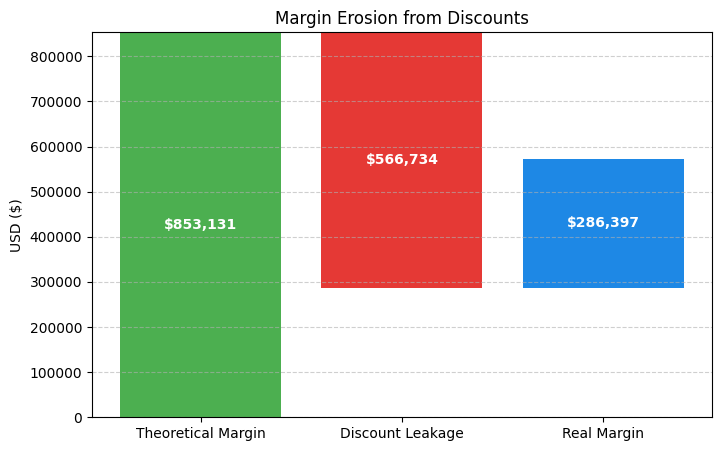

In [45]:
#Grafico Waterfall 
waterfall_simple = pd.DataFrame({
    "Factor": ["Theoretical Margin", "Discount Leakage", "Real Margin"],
    "Value": [total_theoretical, -discount_leakage_total, total_real]
})
waterfall_simple["Base"] = waterfall_simple["Value"].cumsum() - waterfall_simple["Value"]

colors = ["#4CAF50", "#E53935", "#1E88E5"]  # verde, rojo, azul

plt.figure(figsize=(8,5))
bars = plt.bar(waterfall_simple["Factor"],
        waterfall_simple["Value"],
        bottom=waterfall_simple["Base"],
        color=colors)

for bar in bars:
    height = bar.get_height()
    if height >= 0:
        plt.text(bar.get_x() + bar.get_width()/2, 
                 bar.get_y() + height/2, 
                 f"${height:,.0f}", 
                 ha='center', va='center', color="white", fontweight="bold")
    else:
        plt.text(bar.get_x() + bar.get_width()/2, 
                 bar.get_y() + height/2, 
                 f"${-height:,.0f}", 
                 ha='center', va='center', color="white", fontweight="bold")

plt.ylabel("USD ($)")
plt.title("Margin Erosion from Discounts")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

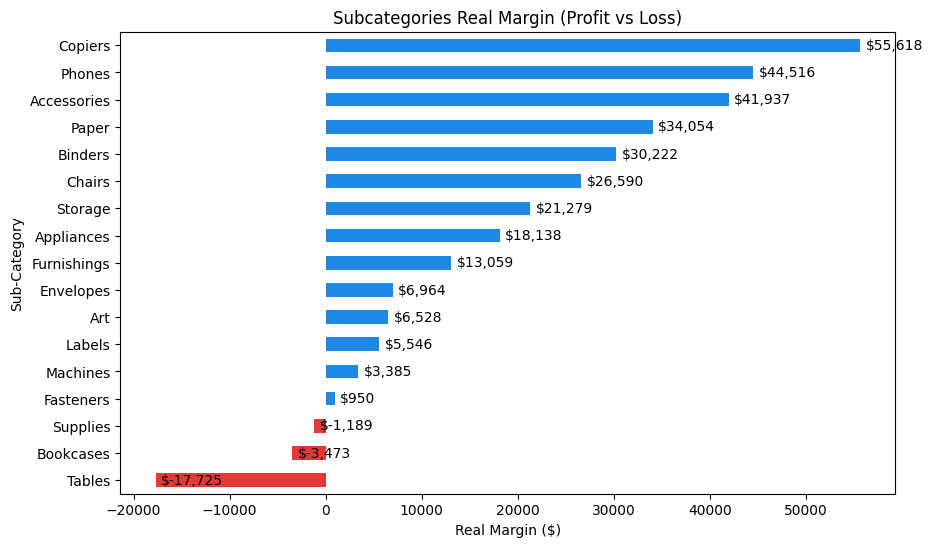

In [51]:
#Grafico de barras por subcategorias
top_subcats = df.groupby("Sub-Category")["margin_real"].sum().sort_values()

plt.figure(figsize=(10,6))

colors = ['#1E88E5' if v >= 0 else '#E53935' for v in top_subcats]

bars = top_subcats.plot(kind="barh", color=colors)

for i, v in enumerate(top_subcats):
    plt.text(v + (max(top_subcats)*0.01), i, f"${v:,.0f}", va='center')

plt.title("Subcategories Real Margin (Profit vs Loss)")
plt.xlabel("Real Margin ($)")
plt.show()

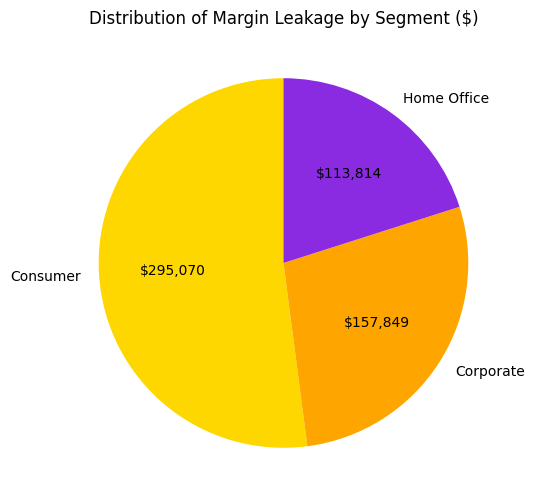

In [49]:
#Grafico de pérdida por segmento
plt.figure(figsize=(6,6))
plt.pie(seg_leakage, 
        labels=seg_leakage.index, 
        autopct=autopct_format(seg_leakage.values),
        colors=["#FFD700", "#FFA500", "#8A2BE2"], 
        startangle=90)
plt.title("Distribution of Margin Leakage by Segment ($)")
plt.show()